In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_json("tlip_like_consignments_5000.jsonl", lines=True)
df.head(5)

,consignment_id,created_at,origin_country,destination_country,origin_port,destination_port,shipment_mode,commodity,hs_code,gross_weight_kg,...,customs_release_hours,terminal_dwell_hours,sla_hours,total_processing_hours,delayed_flag,delay_hours,bl_or_awb_no,container_no,documents,events
0,TLIP-SYN-000001,2025-02-21 09:38:50,RW,ES,Kigali,Madrid,AIR,Mangoes,804,7636.85,...,42.65,37.66,48,80.32,1,4.32,802-78096246,,"[{'consignment_id': 'TLIP-SYN-000001', 'doc_ty...","[{'consignment_id': 'TLIP-SYN-000001', 'event'..."
1,TLIP-SYN-000002,2025-01-13 05:46:46,RW,IT,Kigali,Genoa,AIR,Fresh Beans,708,21069.24,...,50.00,25.19,48,75.19,0,0.00,148-27192561,,"[{'consignment_id': 'TLIP-SYN-000002', 'doc_ty...","[{'consignment_id': 'TLIP-SYN-000002', 'event'..."
2,TLIP-SYN-000003,2025-09-19 04:40:34,TZ,NL,Dar es Salaam,Rotterdam,AIR,Cut Flowers,603,15769.06,...,31.82,29.51,48,61.34,0,0.00,252-21633769,,"[{'consignment_id': 'TLIP-SYN-000003', 'doc_ty...","[{'consignment_id': 'TLIP-SYN-000003', 'event'..."
3,TLIP-SYN-000004,2025-12-04 07:26:32,RW,DE,Kigali,Frankfurt,AIR,Cut Flowers,603,21497.58,...,46.19,38.15,48,84.34,1,8.34,901-77635129,,"[{'consignment_id': 'TLIP-SYN-000004', 'doc_ty...","[{'consignment_id': 'TLIP-SYN-000004', 'event'..."
4,TLIP-SYN-000005,2025-05-08 16:09:41,ET,FR,Addis Ababa-ADD,Paris-CDG,SEA,Pineapples,804,21298.46,...,58.94,85.32,96,144.26,1,20.26,BL823732870,XCDZ0728567,"[{'consignment_id': 'TLIP-SYN-000005', 'doc_ty...","[{'consignment_id': 'TLIP-SYN-000005', 'event'..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   consignment_id          5000 non-null   object        
 1   created_at              5000 non-null   datetime64[ns]
 2   origin_country          5000 non-null   object        
 3   destination_country     5000 non-null   object        
 4   origin_port             5000 non-null   object        
 5   destination_port        5000 non-null   object        
 6   shipment_mode           5000 non-null   object        
 7   commodity               5000 non-null   object        
 8   hs_code                 5000 non-null   int64         
 9   gross_weight_kg         5000 non-null   float64       
 10  declared_value_usd      5000 non-null   float64       
 11  exporter_profile        5000 non-null   object        
 12  doc_completeness_score  5000 non-null   float64 

In [7]:
df.describe()


,created_at,hs_code,gross_weight_kg,declared_value_usd,doc_completeness_score,missing_docs_proxy,doc_amendments,congestion_index,is_weekend_created,customs_release_hours,terminal_dwell_hours,sla_hours,total_processing_hours,delayed_flag,delay_hours
count,5000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,2025-05-15 12:26:12.333800192,818.200800,17355.272310,47651.335412,0.912280,0.779000,0.569000,0.431820,0.278200,47.146678,51.454264,70.526400,98.600904,0.483800,8.537048
min,2024-10-16 02:19:04,603.000000,2000.000000,1600.000000,0.713000,0.000000,0.000000,0.000000,0.000000,6.000000,6.000000,48.000000,18.860000,0.000000,0.000000
25%,2025-01-29 06:45:55.500000,708.000000,12100.437500,27729.320000,0.870000,0.000000,0.000000,0.261000,0.000000,36.717500,32.787500,48.000000,70.760000,0.000000,0.000000
50%,2025-05-13 17:05:47,804.000000,16929.755000,43391.385000,0.914000,1.000000,0.000000,0.414500,0.000000,46.925000,49.210000,48.000000,96.800000,0.000000,0.000000
75%,2025-08-30 19:05:12.750000128,902.000000,22064.062500,62551.820000,0.959000,1.000000,1.000000,0.587000,1.000000,57.370000,70.062500,96.000000,124.980000,1.000000,14.292500
max,2025-12-15 23:51:42,1211.000000,51578.540000,224526.420000,1.000000,3.000000,5.000000,1.000000,1.000000,94.430000,127.540000,96.000000,201.060000,1.000000,77.060000
std,NaN,170.777984,7696.399211,27312.612578,0.058187,0.613705,0.764824,0.215877,0.448157,14.290495,22.939310,23.677733,34.580239,0.499787,12.833571


In [13]:
# Check for duplicate rows (exclude list-like/unhashable columns)
# These columns are likely lists/dicts per the data dictionary and cannot be hashed
hashable_cols = [c for c in df.columns if c not in ["documents", "events"]]

print(f"Number of duplicate rows (on hashable columns): {df.duplicated(subset=hashable_cols).sum()}")
print(f"\nTotal duplicate rows (including first occurrence, on hashable columns): {df.duplicated(subset=hashable_cols, keep=False).sum()}")

df[df.duplicated(subset=hashable_cols, keep=False)]

Number of duplicate rows (on hashable columns): 0

Total duplicate rows (including first occurrence, on hashable columns): 0


,consignment_id,created_at,origin_country,destination_country,origin_port,destination_port,shipment_mode,commodity,hs_code,gross_weight_kg,...,customs_release_hours,terminal_dwell_hours,sla_hours,total_processing_hours,delayed_flag,delay_hours,bl_or_awb_no,container_no,documents,events


In [18]:
# Count unique values, ignoring unhashable list-like columns

unique_counts = df[hashable_cols].nunique()
unique_counts

consignment_id            5000
created_at                4999
origin_country               5
destination_country          7
origin_port                  8
destination_port            14
shipment_mode                2
commodity                    8
hs_code                      6
gross_weight_kg           4888
declared_value_usd        4998
exporter_profile             3
doc_completeness_score     250
missing_docs_proxy           4
doc_amendments               6
congestion_index           910
is_weekend_created           2
customs_release_hours     3236
terminal_dwell_hours      3740
sla_hours                    3
total_processing_hours    4159
delayed_flag                 2
delay_hours               1860
bl_or_awb_no              5000
container_no              2309
dtype: int64

<Axes: xlabel='shipment_mode'>

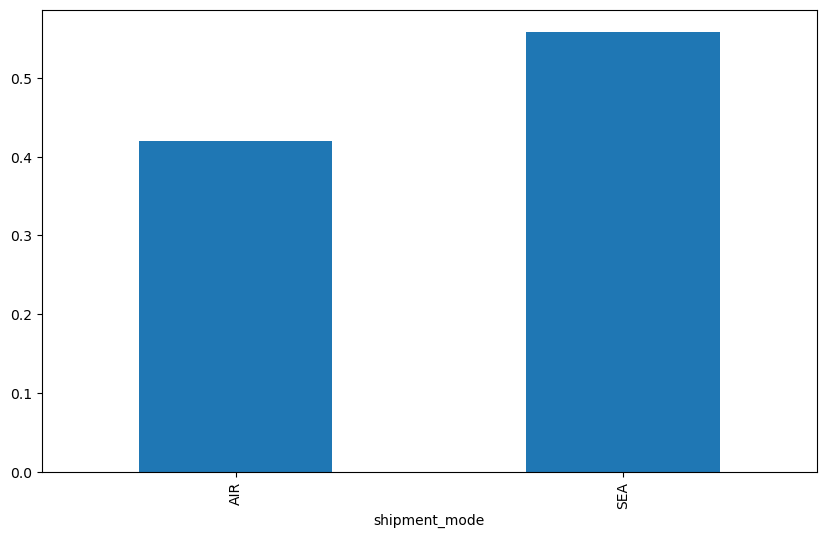

In [20]:
#Check delayed consignments per shipment mode and plot

# Group by shipment mode and calculate delayed consignments
delayed_consignments = df.groupby('shipment_mode')['delayed_flag'].mean()

# Plot the results
delayed_consignments.plot(kind='bar', figsize=(10, 6))

<Axes: xlabel='origin_country'>

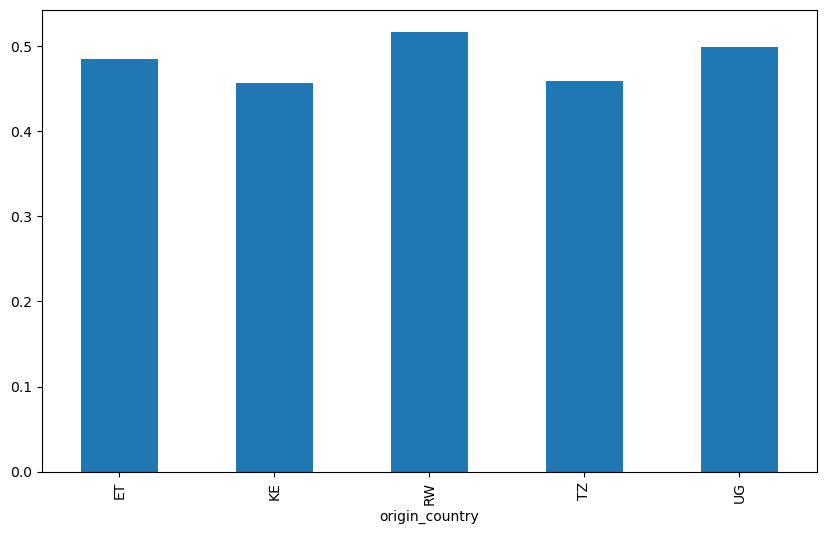

In [21]:
#Chack delayed consignments per origin and plot

# Group by origin and calculate delayed consignments
delayed_consignments_origin = df.groupby('origin_country')['delayed_flag'].mean()

# Plot the results
delayed_consignments_origin.plot(kind='bar', figsize=(10, 6))

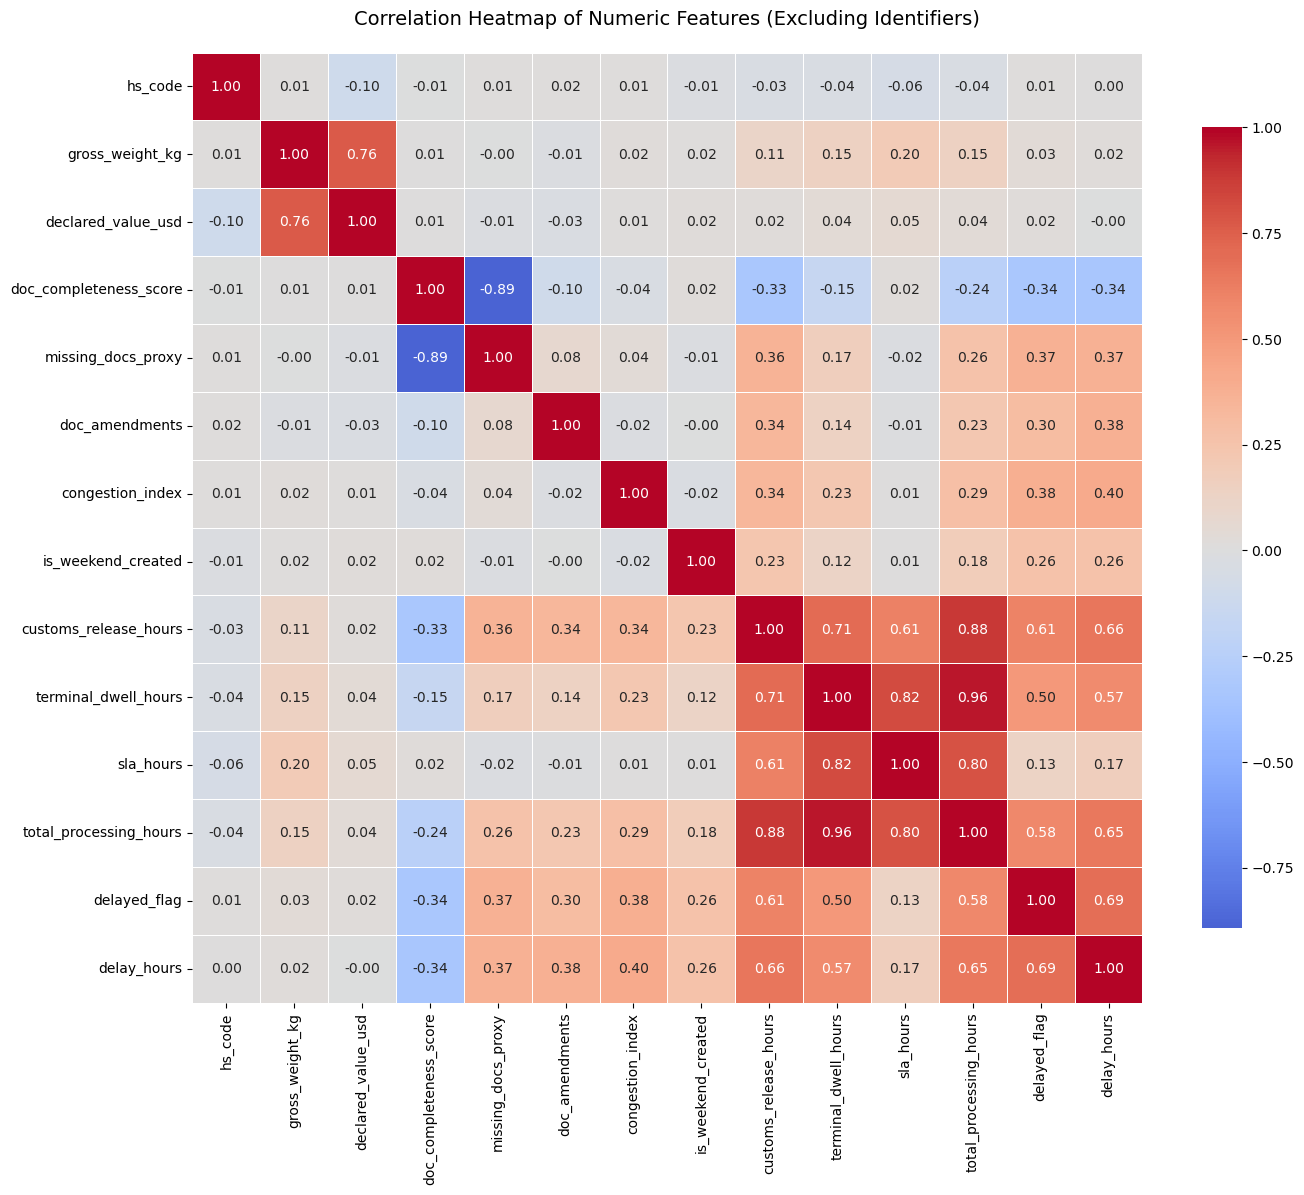

In [23]:
# Check for correlation between delayed consignments and all other features
# Remove identifiers and non-numeric columns

# Identify columns to exclude (identifiers and non-numeric)
identifiers = ['consignment_id', 'bl_or_awb_no', 'container_no', 'documents', 'events']
non_numeric = ['created_at', 'origin_country', 'destination_country', 'origin_port', 
               'destination_port', 'shipment_mode', 'commodity', 'exporter_profile']

# Select only numeric columns (excluding identifiers)
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in identifiers]

# Calculate correlation matrix
correlation_matrix = df[numeric_cols].corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap of Numeric Features (Excluding Identifiers)', 
          fontsize=14, pad=20)
plt.tight_layout()
plt.show()
